In [1]:
%%capture
!pip install transformers
!pip install evaluate
!pip install modAL
!pip install skorch

In [2]:

import pandas as pd
import torch
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import random
import json

In [3]:

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
sns.set_theme()

In [5]:
# set the seed: built-in python, numpy, and pytorch
seed = 13
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [6]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
device

device(type='cuda')

In [7]:
from transformers import AutoTokenizer, AutoModel,AutoModelForSequenceClassification

In [ ]:
# load model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
model=AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased",num_labels=2)#,ignore_mismatched_sizes=True)

In [8]:

text = []
with open('/content/climate-fever-dataset-r1.jsonl') as f:
    for jsonObj in f:
        t = json.loads(jsonObj)
        text.append(t)

In [9]:
df=pd.DataFrame(columns=['claim','label'])
for i in text:
  row={'claim':i['claim'],'label':i['claim_label']}
  df=df.append(row,ignore_index=True)

df['label']=df['label'].apply(lambda x: 1 if x=='SUPPORTS' else 0)

In [ ]:
df['label'].value_counts()

0    881
1    654
Name: label, dtype: int64

In [ ]:
df.shape

(1535, 2)

In [18]:
# labeled_samples['label'].value_counts()

0    139
1     95
Name: label, dtype: int64

In [13]:
all_data=df

In [14]:
x_train,x_test,y_train,y_test=train_test_split(all_data['claim'].to_list(),all_data['label'].to_list(),random_state=13,stratify=all_data['label'].to_list())

In [ ]:
#baseline

In [12]:
x_train_tok=tokenizer(x_train, truncation=True,max_length=330,padding=True,return_tensors='pt')#can use the max len+10/20 from the corpus (power of 2)
x_test_tok=tokenizer(x_test, truncation=True,max_length=330,padding=True,return_tensors='pt')

In [11]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)
    
train_dataset = Dataset(x_train_tok, y_train)
#val_dataset = IMDbDataset(val_encodings, val_labels)
test_dataset = Dataset(x_test_tok, y_test)

NameError: ignored

In [14]:
from transformers import TrainingArguments
import evaluate
from transformers import TrainingArguments, Trainer

In [26]:
metric=evaluate.load("accuracy")

In [27]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [28]:
training_args = TrainingArguments( 
    learning_rate=5e-5,
    num_train_epochs=3,
    #evaluation_strategy="epoch",
    per_device_train_batch_size=8,#8
    per_device_eval_batch_size=8,
    logging_steps=200,
    output_dir="outputs",
    overwrite_output_dir=True,
    evaluation_strategy="epoch")

In [29]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

In [30]:
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 1151
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 432
  Number of trainable parameters = 66955010
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.618343,0.661458
2,0.649700,0.764754,0.664062
3,0.418300,0.818310,0.656250


***** Running Evaluation *****
  Num examples = 384
  Batch size = 8
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
***** Running Evaluation *****
  Num examples = 384
  Batch size = 8
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
***** Running Evaluation *****
  Num examples = 384
  Batch size = 8


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=432, training_loss=0.5171203789887605, metrics={'train_runtime': 35.3847, 'train_samples_per_second': 97.585, 'train_steps_per_second': 12.209, 'total_flos': 73257058710648.0, 'train_loss': 0.5171203789887605, 'epoch': 3.0})

In [31]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 384
  Batch size = 8
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


{'eval_loss': 0.8183095455169678,
 'eval_accuracy': 0.65625,
 'eval_runtime': 0.8913,
 'eval_samples_per_second': 430.845,
 'eval_steps_per_second': 53.856,
 'epoch': 3.0}

In [10]:
unlabeled_index=random.sample(range(0,1151),1051)
labeled_index=list(set(range(1151))-set(unlabeled_index))


In [15]:
unlabeled_samples=pd.DataFrame(columns=['claim','label'])
unlabeled_samples['claim']=[x_train[i] for i in unlabeled_index]
unlabeled_samples['label']=[y_train[i] for i in unlabeled_index]

In [16]:
labeled_samples=pd.DataFrame(columns=['claim','label'])
labeled_samples['claim']=[x_train[i] for i in labeled_index]
labeled_samples['label']=[y_train[i] for i in labeled_index]

Use modAL

In [17]:
from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling
from skorch import NeuralNetClassifier, NeuralNet
from sklearn.pipeline import Pipeline
from skorch.callbacks import LRScheduler, ProgressBar
from skorch.hf import HuggingfacePretrainedTokenizer

In [18]:
# Choose a tokenizer and BERT model that work together
TOKENIZER = "distilbert-base-uncased"# "nbroad/ESG-BERT"
PRETRAINED_MODEL = "distilbert-base-uncased"#"nbroad/ESG-BERT"
OPTMIZER = torch.optim.AdamW
LR = 5e-5
MAX_EPOCHS = 3
CRITERION = torch.nn.CrossEntropyLoss
BATCH_SIZE = 8
DEVICE='cuda'

In [19]:
tokenizer=HuggingfacePretrainedTokenizer(TOKENIZER)

In [20]:
X_initial=labeled_samples['claim'].to_numpy()
#tokenizer.fit(X_initial,max_length=330)
#X_initial=tokenizer.transform(X_initial)


y_initial=labeled_samples['label'].to_numpy()

In [21]:
X_pool=unlabeled_samples['claim'].to_numpy()
y_pool=unlabeled_samples['label'].to_numpy()

In [40]:
labeled_samples['label'].value_counts()

0    66
1    34
Name: label, dtype: int64

In [22]:
X_test=x_test


In [23]:
class BertModule(torch.nn.Module):
    def __init__(self, name, num_labels):
        super().__init__()
        self.name = name
        self.num_labels = num_labels
        
        self.reset_weights()
        
    def reset_weights(self):
        self.bert = AutoModelForSequenceClassification.from_pretrained(
            self.name, num_labels=self.num_labels#,ignore_mismatched_sizes=True
        )
        
    def forward(self, **kwargs):
        pred = self.bert(**kwargs)
        return pred.logits

In [24]:
pipeline = Pipeline([
    ('tokenizer', HuggingfacePretrainedTokenizer(TOKENIZER)),
    ('net', NeuralNetClassifier(
        BertModule,
        module__name=PRETRAINED_MODEL,
        module__num_labels=2,
        optimizer=OPTMIZER,
        lr=LR,
        max_epochs=MAX_EPOCHS,
        criterion=CRITERION,
        batch_size=BATCH_SIZE,
        iterator_train__shuffle=True,
        device=DEVICE,
        #callbacks=[
            #LRScheduler(LambdaLR, lr_lambda=lr_schedule, step_every='batch'),
           # ProgressBar(),
        #],
    )),
])

In [ ]:
# pipeline.fit(X_initial,y_initial)

In [35]:
learner = ActiveLearner(
    estimator=pipeline,
    X_training=X_initial, y_training=y_initial
)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6844       0.7000        0.6062  2.1564
      2        0.6409       0.7000        0.6141  2.1092
      3        0.5096       0.7000        0.7119  2.1071


In [44]:
y_pred=learner.predict(X_test)
print(accuracy_score(np.array(y_test),np.array(y_pred)))

0.5729166666666666


In [51]:
with torch.inference_mode():
    y_pred = pipeline.predict(X_test)

print(accuracy_score(np.array(y_test),np.array(y_pred)))

0.5729166666666666


In [47]:
# classifier = NeuralNetClassifier(BertModule,
#                                 module__name=PRETRAINED_MODEL,
#                                  module__num_labels=2,
#                                  criterion=torch.nn.CrossEntropyLoss,
#                                  optimizer=torch.optim.AdamW,
#                                  train_split=None,
#                                  verbose=1,
#                                  device=DEVICE)

In [36]:
performance_hist=[]
n_queries = 10
for idx in range(n_queries):
    print('Query no. %d' % (idx + 1))
    query_idx, query_instance = learner.query(X_pool,n_instances=100) #
    learner.teach(
        X=X_pool[query_idx], y=y_pool[query_idx], only_new=True,
    )
    # remove queried instance from pool
    X_pool = np.delete(X_pool, query_idx, axis=0)
    y_pool = np.delete(y_pool, query_idx, axis=0)

    with torch.inference_mode():
      y_pred = pipeline.predict(X_test)
    performance_hist.append(accuracy_score(np.array(y_test),np.array(y_pred)))

Query no. 1
Re-initializing module because the following parameters were re-set: name, num_labels.


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier

Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6653       0.6500        0.6491  2.1396
      2        0.6357       0.6500        0.6481  2.1517
      3        0.5122       0.5500        0.7016  2.1625
Query no. 2
Re-initializing module because the following parameters were re-set: name, num_labels.


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier

Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6435       0.6500        0.6382  2.1643
      2        0.5575       0.6500        0.6316  2.1919
      3        0.4803       0.7000        0.7245  2.1963
Query no. 3
Re-initializing module because the following parameters were re-set: name, num_labels.


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier

Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6985       0.6500        0.6574  2.1317
      2        0.6650       0.6500        0.6535  2.1881
      3        0.6079       0.6500        0.6528  2.2605
Query no. 4
Re-initializing module because the following parameters were re-set: name, num_labels.


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier

Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.7088       0.5000        0.6966  2.1182
      2        0.6952       0.4500        0.6918  2.1317
      3        0.6219       0.5000        0.6657  2.1331
Query no. 5
Re-initializing module because the following parameters were re-set: name, num_labels.


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier

Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6746       0.4500        0.6915  2.1331
      2        0.5191       0.6000        0.7558  2.1374
      3        0.2109       0.5000        1.0656  2.1469
Query no. 6
Re-initializing module because the following parameters were re-set: name, num_labels.


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier

Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6996       0.5500        0.6785  2.1458
      2        0.5879       0.4500        0.6524  2.1714
      3        0.3073       0.5500        0.8269  2.1670
Query no. 7
Re-initializing module because the following parameters were re-set: name, num_labels.


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier

Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.7302       0.5500        0.6959  2.1506
      2        0.6769       0.4500        0.6931  2.1590
      3        0.5444       0.5000        0.7612  2.1584
Query no. 8
Re-initializing module because the following parameters were re-set: name, num_labels.


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier

Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6781       0.6500        0.6553  2.1293
      2        0.6191       0.6500        0.6655  2.1483
      3        0.3620       0.6500        1.1591  2.1507
Query no. 9
Re-initializing module because the following parameters were re-set: name, num_labels.


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier

Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6839       0.5500        0.7452  2.1377
      2        0.5918       0.3000        0.7913  2.1443
      3        0.3092       0.3500        1.3883  2.1443
Query no. 10
Re-initializing module because the following parameters were re-set: name, num_labels.


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier

Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6505       0.6500        0.6609  2.1348
      2        0.5421       0.5000        0.7788  2.1530
      3        0.2925       0.7000        1.1128  2.1471


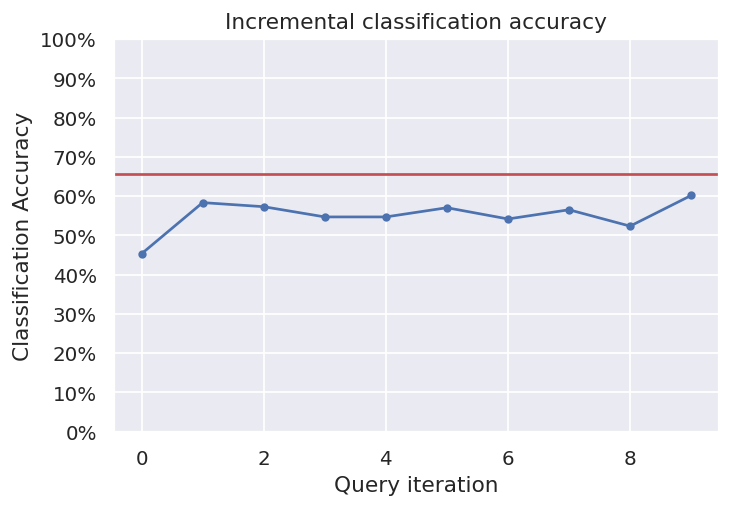

In [37]:
fig, ax = plt.subplots(figsize=(6, 4), dpi=130)

ax.plot(performance_hist)
ax.scatter(range(len(performance_hist)), performance_hist, s=13)

ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=True))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))
plt.axhline(y = 0.6563, color = 'r', linestyle = '-')
ax.set_ylim(bottom=0, top=1)
ax.grid(True)

ax.set_title('Incremental classification accuracy')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification Accuracy')

plt.show()

In [25]:
from functools import partial
from modAL.batch import uncertainty_batch_sampling
from modAL.uncertainty import margin_sampling, entropy_sampling

In [65]:
learner = ActiveLearner( #use margin_sampling
  estimator=pipeline,

  X_training=X_initial,  y_training=y_initial,
  #query_strategy=preset_batch
  query_strategy=margin_sampling
)

Re-initializing module because the following parameters were re-set: name, num_labels.


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier

Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6545       0.7000        0.6180  2.0987
      2        0.6078       0.7000        0.6273  2.0104
      3        0.3952       0.5000        0.8448  1.9922


In [66]:
performance_hist=[]
for idx in range(n_queries):
  print('Query no. %d' % (idx + 1))
  query_idx, query_instance = learner.query(X_pool,n_instances=100) #
  learner.teach(
      X=X_pool[query_idx], y=y_pool[query_idx]
  )
    # remove queried instance from pool
  X_pool = np.delete(X_pool, query_idx, axis=0)
  y_pool = np.delete(y_pool, query_idx, axis=0)

  with torch.inference_mode():
    y_pred = pipeline.predict(X_test)
  performance_hist.append(accuracy_score(np.array(y_test),np.array(y_pred)))

Query no. 1
Re-initializing module because the following parameters were re-set: name, num_labels.


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier

Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6959       0.6000        0.6719  3.9812
      2        0.6092       0.4750        0.7010  4.0058
      3        0.4930       0.6250        0.9071  4.0168
Query no. 2
Re-initializing module because the following parameters were re-set: name, num_labels.


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier

Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6844       0.5833        0.7154  6.0526
      2        0.6881       0.5833        0.6907  6.0861
      3        0.5580       0.5667        0.7780  6.1108
Query no. 3
Re-initializing module because the following parameters were re-set: name, num_labels.


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier

Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6675       0.5875        0.6852  8.1750
      2        0.6510       0.6375        0.6758  8.2116
      3        0.5837       0.6375        0.6536  8.2524
Query no. 4
Re-initializing module because the following parameters were re-set: name, num_labels.


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier

Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        0.6707       0.6000        0.6736  10.3429
      2        0.6211       0.5900        0.7380  10.5535
      3        0.3446       0.6200        1.2877  10.5792
Query no. 5
Re-initializing module because the following parameters were re-set: name, num_labels.


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier

Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        0.6966       0.5667        0.6779  12.5560
      2        0.6658       0.6917        0.6500  12.5987
      3        0.5510       0.5750        0.7162  12.6268
Query no. 6
Re-initializing module because the following parameters were re-set: name, num_labels.


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier

Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        0.6781       0.5857        0.6663  14.6701
      2        0.5805       0.6286        0.6291  14.6915
      3        0.3536       0.6000        0.8729  14.7002
Query no. 7
Re-initializing module because the following parameters were re-set: name, num_labels.


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier

Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        0.6908       0.5687        0.6769  16.7679
      2        0.6665       0.6750        0.6248  16.8436
      3        0.5521       0.6500        0.7163  16.9333
Query no. 8
Re-initializing module because the following parameters were re-set: name, num_labels.


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier

Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        0.6899       0.6278        0.6618  19.1030
      2        0.5891       0.6278        0.6651  19.5987
      3        0.3578       0.6167        0.8552  19.6251
Query no. 9
Re-initializing module because the following parameters were re-set: name, num_labels.


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier

Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        0.6899       0.5650        0.6819  21.3947
      2        0.6677       0.6500        0.6313  21.5442
      3        0.5233       0.6100        0.7396  21.7161
Query no. 10
Re-initializing module because the following parameters were re-set: name, num_labels.


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier

Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        0.6880       0.5727        0.6741  23.6604
      2        0.6163       0.6273        0.6479  23.7481
      3        0.4456       0.6318        0.6444  23.7785


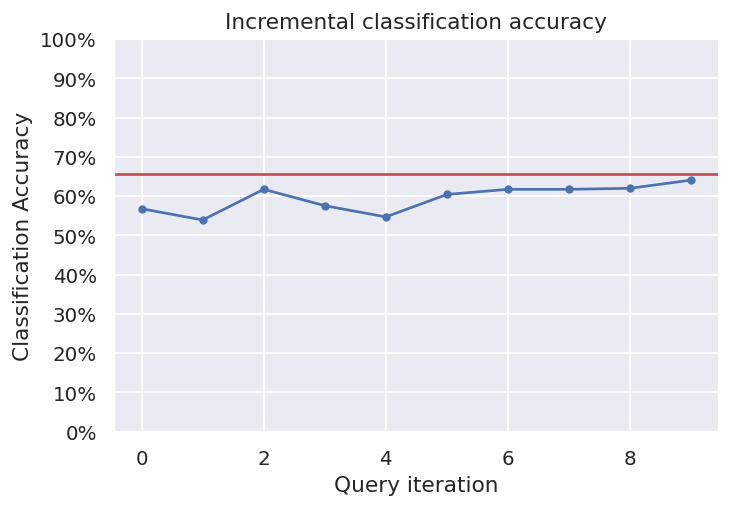

In [67]:
fig, ax = plt.subplots(figsize=(6, 4), dpi=130)

ax.plot(performance_hist)
ax.scatter(range(len(performance_hist)), performance_hist, s=13)

ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=True))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))
plt.axhline(y = 0.6563, color = 'r', linestyle = '-')
ax.set_ylim(bottom=0, top=1)
ax.grid(True)

ax.set_title('Incremental classification accuracy')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification Accuracy')

plt.show()

In [26]:
learner = ActiveLearner( #use margin_sampling
  estimator=pipeline,

  X_training=X_initial,  y_training=y_initial,
  #query_strategy=preset_batch
  query_strategy=entropy_sampling
)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6664       0.7000        0.6289  4.2459
      2        0.6006       0.7000        0.5941  1.8089
      3        0.4598       0.7000        0.6436  1.8264


In [27]:
performance_hist=[]
n_queries=10
for idx in range(n_queries):
  print('Query no. %d' % (idx + 1))
  query_idx, query_instance = learner.query(X_pool,n_instances=100) #
  learner.teach(
      X=X_pool[query_idx], y=y_pool[query_idx]
  )
    # remove queried instance from pool
  X_pool = np.delete(X_pool, query_idx, axis=0)
  y_pool = np.delete(y_pool, query_idx, axis=0)

  with torch.inference_mode():
    y_pred = pipeline.predict(X_test)
  performance_hist.append(accuracy_score(np.array(y_test),np.array(y_pred)))

Query no. 1
Re-initializing module because the following parameters were re-set: name, num_labels.


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier

Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6958       0.5250        0.6865  3.7355
      2        0.6195       0.6250        0.6739  3.6900
      3        0.3238       0.5500        1.1795  3.6924
Query no. 2
Re-initializing module because the following parameters were re-set: name, num_labels.


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier

Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6920       0.5833        0.6817  5.6918
      2        0.5870       0.5667        0.7732  5.6747
      3        0.2684       0.6167        0.8861  5.7117
Query no. 3
Re-initializing module because the following parameters were re-set: name, num_labels.


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier

Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.7064       0.5125        0.6922  7.8166
      2        0.6898       0.5500        0.6839  7.8394
      3        0.6144       0.6750        0.6086  7.9079
Query no. 4
Re-initializing module because the following parameters were re-set: name, num_labels.


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier

Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6970       0.7000        0.6808  9.7869
      2        0.6450       0.6700        0.6433  9.7146
      3        0.4538       0.6600        0.7716  9.6980
Query no. 5
Re-initializing module because the following parameters were re-set: name, num_labels.


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier

Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        0.6915       0.5500        0.6861  11.7769
      2        0.6607       0.5500        0.7307  11.6826
      3        0.4298       0.6000        0.7304  11.8017
Query no. 6
Re-initializing module because the following parameters were re-set: name, num_labels.


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier

Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        0.6872       0.5571        0.6885  13.6138
      2        0.6912       0.4357        0.6964  13.7249
      3        0.6597       0.6000        0.6304  13.6580
Query no. 7
Re-initializing module because the following parameters were re-set: name, num_labels.


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier

Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        0.6835       0.6500        0.6432  15.5891
      2        0.5433       0.6438        0.6825  15.6098
      3        0.1644       0.5875        1.3192  15.6007
Query no. 8
Re-initializing module because the following parameters were re-set: name, num_labels.


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier

Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        0.6817       0.5889        0.6697  17.5769
      2        0.5724       0.6778        0.6094  17.5463
      3        0.2556       0.6556        0.9606  17.5184
Query no. 9
Re-initializing module because the following parameters were re-set: name, num_labels.


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier

Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        0.6840       0.6050        0.6439  19.4672
      2        0.5950       0.6450        0.6201  19.4884
      3        0.2830       0.6150        0.8895  19.5244
Query no. 10
Re-initializing module because the following parameters were re-set: name, num_labels.


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier

Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        0.6819       0.6227        0.6572  21.3857
      2        0.6164       0.6227        0.6398  21.4894
      3        0.4593       0.5455        0.9069  21.4547


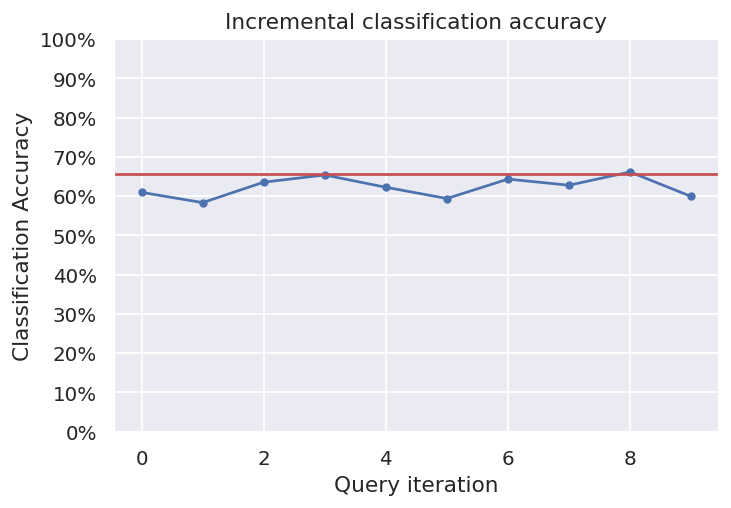

In [28]:
fig, ax = plt.subplots(figsize=(6, 4), dpi=130)

ax.plot(performance_hist)
ax.scatter(range(len(performance_hist)), performance_hist, s=13)

ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=True))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))
plt.axhline(y = 0.6563, color = 'r', linestyle = '-')
ax.set_ylim(bottom=0, top=1)
ax.grid(True)

ax.set_title('Incremental classification accuracy')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification Accuracy')

plt.show()